## Check Architecture

In [2]:
import torch

torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

## Define Model Architecture

The UNet model is a convolutional neural network architecture designed for semantic segmentation tasks, such as image denoising. It consists of an encoder-decoder structure with skip connections, allowing it to capture both low-level and high-level features in the input image.

The model starts with an initial convolutional layer called `inc`, which applies a double convolution operation to the input image. This layer helps extract basic features from the input.

The encoder part of the model consists of four downsampling blocks, `down1` to `down4`. Each downsampling block performs a max pooling operation followed by a double convolution operation. The max pooling operation reduces the spatial dimensions of the feature maps, while the double convolution operation further extracts and refines the features.

The decoder part of the model consists of four upsampling blocks, `up1` to `up4`. Each upsampling block performs an upsampling operation followed by a double convolution operation. The upsampling operation increases the spatial dimensions of the feature maps, while the double convolution operation helps to recover the lost details during the downsampling process.

The skip connections in the model are established by concatenating the feature maps from the encoder with the corresponding feature maps from the decoder. This allows the model to preserve and utilize the low-level details captured by the encoder while combining them with the high-level contextual information from the decoder.

The final output of the model is obtained by passing the concatenated feature maps through the `outc` layer, which applies a 1x1 convolution to produce the desired number of output channels.

The choice of the UNet architecture for denoising tasks is beneficial for several reasons. Firstly, the skip connections enable the model to effectively capture and utilize both local and global information, allowing it to denoise images while preserving important details. Secondly, the double convolution layers in each block help to learn complex patterns and features in the input, enhancing the denoising performance. Lastly, the UNet architecture has been widely used and proven effective in various image segmentation tasks, making it a reliable choice for denoising CNNs.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """A class representing a double convolutional layer.
    
    This class performs two convolutions followed by batch normalization and LeakyReLU activation.
    """

    def __init__(self, in_channels, out_channels, mid_channels=None):
        """
        Initializes the DoubleConv layer.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            mid_channels (int, optional): Number of intermediate channels. Defaults to None.
                If not provided, it is set to the same value as out_channels.
        """
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )

    def forward(self, x):
        """
        Performs a forward pass through the DoubleConv layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the double convolution.
        """
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        bilinear (bool, optional): Whether to use bilinear upsampling or transpose convolution. 
            Defaults to True.
    
    Attributes:
        up (nn.Module): Upsampling layer.
        conv (DoubleConv): Double convolution layer.
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Initializes an instance of the OutConv class.

        Args:
            in_channels (int): The number of input channels.
            out_channels (int): The number of output channels.
        """
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        """
        Performs a forward pass through the OutConv layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        return self.conv(x)

class UNet(nn.Module):
    """
    U-Net architecture for semantic segmentation.

    Args:
        n_channels (int): Number of input channels.
        n_classes (int): Number of output classes.

    Attributes:
        n_channels (int): Number of input channels.
        n_classes (int): Number of output classes.
        inc (DoubleConv): DoubleConv module for the initial convolution layers.
        down1 (Down): Down module for the first downsampling operation.
        down2 (Down): Down module for the second downsampling operation.
        down3 (Down): Down module for the third downsampling operation.
        down4 (Down): Down module for the fourth downsampling operation.
        up1 (Up): Up module for the first upsampling operation.
        up2 (Up): Up module for the second upsampling operation.
        up3 (Up): Up module for the third upsampling operation.
        up4 (Up): Up module for the fourth upsampling operation.
        outc (OutConv): OutConv module for the final convolution layer.

    """

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


## Define Data Loader

In [24]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

import random as rand
import torch
from torchvision.transforms import v2 as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AddGaussianNoise(object):
    def __init__(self, random_interval):
        """
        Args:
            random_interval:        Interval to randomly sample
            tuple(float, float)     the standard deviation of the 
                                    Gaussian noise to add.
        """
        self.mean = 0
        self.std = round(rand.uniform(random_interval[0], random_interval[1]), 4)

    def __call__(self, img):
        """
        Args:
            img (PIL.Image or torch.Tensor): Image to be noised

        Returns:
            PIL.Image or torch.Tensor: Noised image
        """
        if isinstance(img, torch.Tensor):
            noise = torch.normal(self.mean, self.std, img.size()).to(device)
            noisy_img_tensor = img.to(device) + noise
            return torch.clamp(noisy_img_tensor, 0, 1)
            
        else:
            # Convert image to tensor, add noise, and convert back if the input is a PIL Image
            img_tensor = transforms.PILToTensor()(img)
            noise = torch.randn(img_tensor.size()) * self.std + self.mean
            noised_img = img_tensor + noise
            noised_img = torch.clamp(noised_img, 0, 255)
            return transforms.ToPILImage()(noised_img)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def check_and_flip_image(image):
    width, height = image.size
    if height > width:
        image = image.transpose(Image.ROTATE_90)
    return image


class DenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            - root_dir (string): Directory with all the images.
            - noise_level (int): Specific noise level of noisy images to use.
            - transform (callable, optional): Optional transform to be applied on a sample.
        """
        dataset_split = 0.9
        original_fnames = os.listdir(os.path.join(root_dir, "original_png"))

        dataset_fnames = (
            original_fnames[: int(len(original_fnames) * dataset_split)]
            if train
            else original_fnames[int(len(original_fnames) * dataset_split) :]
        )

        self.root_dir = root_dir
        self.transform = transform
        self.image_objects = [
            {"img_id": fname[:-4]}
            for fname in dataset_fnames
        ]

    def __len__(self):
        return len(self.image_objects)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_object = self.image_objects[idx]

        original_img_path = os.path.join(
            self.root_dir, "original_png", f"{img_object['img_id']}.png"
        )

        original_image = Image.open(original_img_path).convert("RGB")

        original_image = check_and_flip_image(original_image)

        if self.transform:
            original_image = self.transform(original_image)

        noise_transform = AddGaussianNoise((0.05, 0.4))
        noisy_image = noise_transform(original_image)

        return noisy_image, original_image

## Train Function

In [5]:
import time
import datetime
from IPython.display import display, clear_output


def train(model, dataloader, optimiser, criterion, epochs):
    losses_storage = []
    average_batch_time = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.train()
    model.to(device)

    print("Training started\n")

    last_epoch_loss = 'N/A'
    for epoch in range(epochs):
        running_loss = 0.0

        for i, (noisy_images, original_images) in enumerate(dataloader):
            batch_time = time.time()
            noisy_images = noisy_images.to(device)
            original_images = original_images.to(device)

            optimiser.zero_grad()
            outputs = model(noisy_images)

            loss = criterion(outputs, original_images)
            loss.backward()

            optimiser.step()
            running_loss += loss.item()
            losses_storage.append(loss.item())

            # calculating the percentage done and ETA
            total_epochs = epochs
            total_batches = len(dataloader)
            current_batch_num = epoch * total_batches + i + 1

            percentage = (current_batch_num / (total_epochs * total_batches)) * 100

            average_batch_time = (
                average_batch_time * (current_batch_num - 1)
                + (time.time() - batch_time)
            ) / (current_batch_num)

            time_remaining = average_batch_time * (
                total_epochs * total_batches - current_batch_num
            )
            eta = datetime.datetime.now() + datetime.timedelta(seconds=round(time_remaining))

            clear_output(wait=False)

            print("Training started\n")
            print(
                f"Current State\n-------------\nEpoch: {epoch+1}/{total_epochs} (last epoch loss: {last_epoch_loss}) \nBatch: {i+1}/{total_batches} \nCurrent Loss: {loss.item()} \nPercentage: {percentage:.2f}% \nETA: {eta.strftime('%H:%M:%S')}"
            )
        
        last_epoch_loss = running_loss / len(dataloader)

    print("\n\nTraining finished")
    print(f"Final loss: {losses_storage[-1]}")

    return losses_storage

## Test Function

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)

            loss = criterion(outputs, targets)
            total_loss += loss.item()

    print(f"Test Loss: {total_loss/len(dataloader)}")

## Load Dataset

c:\Users\joshu\Documents\.coding\repos\industrial-vision\.venv-industrial-vision\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


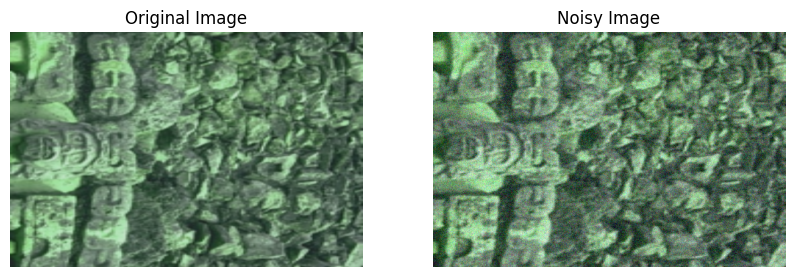

In [60]:
from torchvision.transforms import v2 as transforms

training_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.ScaleJitter((320, 480), (0.9, 1)),
        transforms.RandomOrder(
            [
                transforms.ColorJitter(brightness=(0.75, 1.25)),
                transforms.ColorJitter(contrast=(0.75, 1.25)),
                transforms.ColorJitter(saturation=(0.75, 1.25)),
                transforms.ColorJitter(hue=(-0.2, 0.2)),
            ]
        ),
        transforms.RandomChoice(
            [
                transforms.Compose(
                    [
                        transforms.RandomChoice(
                            [
                                transforms.RandomAffine((10, 80)),
                                transforms.RandomRotation((10, 80)),
                            ]
                        ),
                        transforms.RandomResizedCrop((320, 480), (0.1, 0.1)),
                    ]
                ),
                transforms.RandomResizedCrop((320, 480), (0.5, 1)),
            ]
        ),
    ]
)

test_tranforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((320, 480)),
    ]
)

# transform = transforms.ScaleJitter((320, 480))

training_dataset = DenoisingDataset(
    root_dir="CBSD68", transform=training_transform, train=True
)
test_dataset = DenoisingDataset(
    root_dir="CBSD68", transform=test_tranforms, train=False
)

import matplotlib.pyplot as plt

# Assuming dataset is the instance of AdjustedDenoisingDataset
noisy_image, original_image = training_dataset[
    rand.randint(0, len(training_dataset) - 1)
]

# Convert the tensors to PIL images
noisy_image_pil = transforms.ToPILImage()(noisy_image)
original_image_pil = transforms.ToPILImage()(original_image)

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image_pil)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(noisy_image_pil)
axes[1].set_title("Noisy Image")
axes[1].axis("off")

plt.show()

## Train Model

In [230]:
import torch.optim as optim

num_epochs = 1000
batch_size = 8
lr = 0.005

model = UNet(n_channels=3, n_classes=3)
dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
optimiser = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.MSELoss()

losses_storage = train(model, dataloader, optimiser, criterion, num_epochs)

Training started

Current State
-------------
Epoch: 2/1000 (last epoch loss: 0.19213500223122537) 
Batch: 2/8 
Current Loss: 0.026465635746717453 
Percentage: 0.12% 
ETA: 21:57:00


KeyboardInterrupt: 

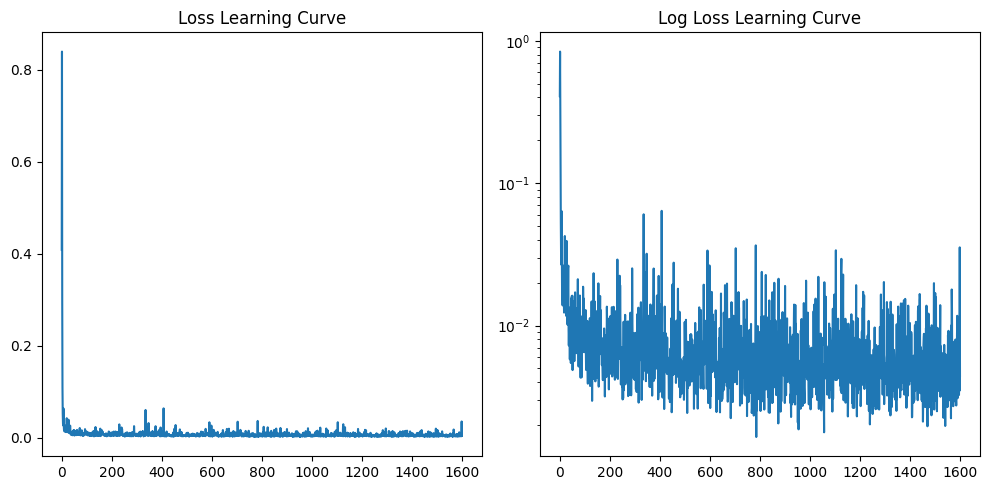

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first plot
axes[0].plot(losses_storage)
axes[0].set_title('Loss Learning Curve')

# Plot the second plot
axes[1].plot(losses_storage)
axes[1].set_yscale('log')
axes[1].set_title('Log Loss Learning Curve')

plt.tight_layout()
plt.show()


In [56]:
dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()

test(model, dataloader, criterion)

Test Loss: 0.0044208732433617115


## Save and Load Model

In [59]:
# Save model
import os

# Create the '2_saved_models' folder if it doesn't exist
save_folder = '2_saved_models'
os.makedirs(save_folder, exist_ok=True)

while True:
  filename = input("Enter filename to save model: \n")
  save_path = os.path.join(save_folder, f'{filename}.pth')
  
  try:
    torch.save(model.state_dict(), save_path)
    break
  except FileExistsError:
    print("File already exists. Please enter a different filename.")


In [ ]:
# Load model
import os

# List all the files in the '2_saved_models' folder
saved_models_folder = '2_saved_models'
model_files = os.listdir(saved_models_folder)

# Display the available model files
print("Available model files:")
for i, file in enumerate(model_files):
    print(f"{i+1}. {file}")

# Prompt the user to enter the index of the model file they want to load
selected_index = int(input("Enter the index of the model file to load: ")) - 1

# Load the selected model file
selected_model_file = model_files[selected_index]
model_path = os.path.join(saved_models_folder, selected_model_file)
model = UNet(n_channels=3, n_classes=3)
model.load_state_dict(torch.load(model_path))

## Test an Image

Loss value (MSE): 0.004264900926500559


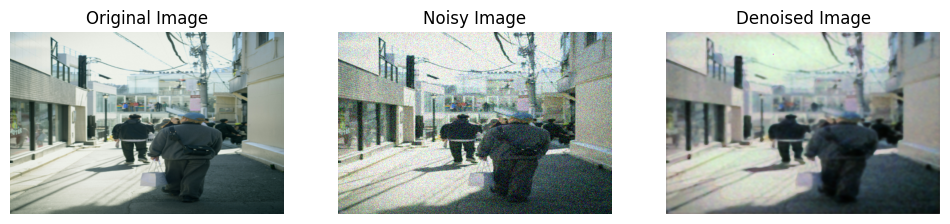

In [58]:
import requests
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from io import BytesIO
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Additional function to convert tensor to PIL Image for visualization
def tensor_to_pil(tensor):
    unloader = transforms.ToPILImage()  # Convert tensor to PIL Image
    image = tensor.cpu().clone()  # Clone the tensor to not do changes on it
    image = image.squeeze(0)      # Remove the fake batch dimension
    image = unloader(image)
    return image

# Function to fetch image
def fetch_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB') 
    return img

# Function to denoise image using model
def denoise_image(image_tensor):
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize((320, 480)),
        transforms.ToTensor(),
        # Add any other preprocessing (e.g., normalization)
    ])

    input_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)
    return output.squeeze(0)  # Remove batch dimension


def process_image(image_url, noise_level):
    original_image = fetch_image(image_url)
    # noisy_image = add_awgn_to_image(original_image, noise_level)
    # Convert original_image to tensor for loss computation
    preprocess = transforms.Compose([
        transforms.Resize((320, 480)),
        transforms.ToTensor(),
    ])
    original_image_tensor = preprocess(original_image).to(device)
    original_image = tensor_to_pil(original_image_tensor)
    noisy_image_tensor = AddGaussianNoise((noise_level, noise_level))(original_image_tensor).to(device)

    denoised_image_tensor = denoise_image(noisy_image_tensor)
    denoised_image = tensor_to_pil(denoised_image_tensor)
    noisy_image = tensor_to_pil(noisy_image_tensor)

    # Compute loss
    loss = F.mse_loss(denoised_image_tensor, original_image_tensor)
    print(f"Loss value (MSE): {loss.item()}")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image)
    plt.title("Noisy Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image)
    plt.title("Denoised Image")
    plt.axis('off')

    plt.show()

image_url = input("Enter the URL of the image to denoise: \n")
noise_level = float(input("Enter the noise level (0-100): \n")) / 100
process_image(image_url, noise_level)
